In [1]:
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import torch

# Import required libraries
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Importing necessary packages
import os
import shap
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.calibration import calibration_curve
#from scikitplot.metrics import plot_precision_recall
from sklearn.metrics import precision_recall_curve, auc
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.metrics import plot_cumulative_gain
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import joblib

import xgboost as xgb
import sqlite3

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

In [2]:
model_name = 'best_model.pkl'

In [3]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [4]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [5]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [6]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [7]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [8]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [9]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [10]:
%%time

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.705963
[100]	valid_0's auc: 0.724362
[150]	valid_0's auc: 0.731423
[200]	valid_0's auc: 0.735874
[250]	valid_0's auc: 0.739009
[300]	valid_0's auc: 0.740965
[350]	valid_0's auc: 0.742924
[400]	valid_0's auc: 0.744582
[450]	valid_0's auc: 0.745977
[500]	valid_0's auc: 0.747033
[550]	valid_0's auc: 0.747877
[600]	valid_0's auc: 0.749039
[650]	valid_0's auc: 0.750087
[700]	valid_0's auc: 0.750863
Early stopping, best iteration is:
[739]	valid_0's auc: 0.751216
CPU times: user 3min 28s, sys: 453 ms, total: 3min 29s
Wall time: 1min 45s


In [11]:
X_train.head(5)

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,totinstallast1m_4525188A,description_5085714M,education_1103M,education_88M,maritalst_385M,maritalst_893M,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
0,NaN,1917.6,0.0,NaN,NaN,NaN,NaN,30000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,4937.0,0.0,NaN,NaN,NaN,NaN,78000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3600.0,0.0,NaN,NaN,NaN,NaN,60000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3110.8,0.0,NaN,NaN,NaN,NaN,20000.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1218.0,0.0,NaN,NaN,NaN,NaN,20300.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
X_train.describe()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,price_1097A,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A
count,5.791220e+05,915995.000000,915994.000000,541137.000000,97373.000000,4.113760e+05,299622.000000,915995.000000,9.159940e+05,9.159940e+05,...,781782.000000,6.486920e+05,4.116090e+05,9.159940e+05,9.159940e+05,211305.000000,86118.000000,68821.000000,43159.000000,343834.000000
mean,5.605103e+04,4039.997497,1438.738468,5399.340343,44660.797975,4.598377e+04,6398.226506,49875.792736,1.971436e+04,1.101732e+04,...,34483.075399,2.773474e+04,2.827702e+04,1.971514e+04,9.245970e+04,10417.497928,9314.901329,10052.182398,17616.446469,13232.382356
std,7.168848e+04,3011.036962,2809.423625,6436.574978,44763.150187,6.441692e+04,9204.315939,44182.879524,5.090623e+04,3.683703e+04,...,34515.060561,5.849688e+04,6.042809e+04,5.090734e+04,1.686761e+05,16187.276163,5568.038917,5530.822134,6777.177534,18190.787187
min,0.000000e+00,83.000000,0.000000,0.000000,0.000000,-7.588198e+06,0.000000,2000.000000,0.000000e+00,0.000000e+00,...,0.000000,-2.405000e+03,-2.405000e+03,0.000000e+00,0.000000e+00,0.222000,0.000000,5.000000,6.000000,0.000000
25%,7.451650e+03,1968.200100,0.000000,2529.800000,15685.800000,8.719109e+03,2595.200000,19998.000000,0.000000e+00,0.000000e+00,...,13811.650750,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3314.600000,6590.600000,7192.200000,13649.400000,3167.616000
50%,2.975565e+04,3151.600000,0.000000,4071.600000,28460.800000,2.278338e+04,4422.000000,35190.000000,0.000000e+00,0.000000e+00,...,25144.200000,0.000000e+00,0.000000e+00,0.000000e+00,3.590924e+04,6216.000000,7305.900000,7553.000000,15765.601000,8400.000000
75%,7.652577e+04,5231.400000,2038.800000,6553.000000,56377.800000,5.536972e+04,7516.200000,63984.000000,1.355695e+04,0.000000e+00,...,45296.000000,2.807435e+04,2.796280e+04,1.355776e+04,1.190084e+05,11697.601000,13027.475000,13464.400000,21829.500500,17005.658500
max,1.198913e+06,91601.400000,71878.600000,496148.800000,513520.000000,1.131136e+06,495910.400000,950000.000000,1.210629e+06,1.028338e+06,...,620400.000000,1.210629e+06,1.085048e+06,1.210629e+06,4.803504e+07,794899.200000,145257.400000,205848.610000,99085.400000,476843.400000


In [13]:
# Define a custom scoring function incorporating validation results
def custom_auc_score(estimator, X, y_true):
    
    # Predict probabilities for the validation set
    y_pred_proba = estimator.predict_proba(X_test)[:, 1]
    
    # Calculate AUC on validation set
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    return auc_score

In [14]:
# Get column names with category dtype
category_columns = X_train.select_dtypes(include=['category']).columns.tolist()

In [15]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

In [16]:
%%time

# Extract column names from X_train
feature_names = X_train.columns.tolist()

categorical_features = category_columns

# Extract numeric features by removing categorical features
numeric_features = [feature for feature in feature_names if feature not in categorical_features]

# Define the preprocessing pipeline with RobustScaler for numeric features
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

# Define the preprocessing pipeline with OneHotEncoder for categorical features
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Check if GPU is available using PyTorch
gpu_available = torch.cuda.is_available()

# Define device to use
device = 'gpu' if gpu_available else 'cpu'
print("Using:",device)

# Define the LightGBM classifier
lgbm_clf = LGBMClassifier(device=device)

# Define Stratified KFold for cross-validation
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Define the hyperparameters grid for LightGBM
param_grid = {
    'classifier__n_estimators': [1000],
    'classifier__max_depth': [5],  # -1 indicates no limit
    'classifier__num_leaves': [3],  # control tree complexity
    'classifier__learning_rate': [0.1],  # control learning rate
    'classifier__subsample': [1.0],  # subsample ratio of the training instance
    'classifier__colsample_bytree': [1.0],  # subsample ratio of columns
    'classifier__class_weight': ['balanced'],  # balance class weights
    'classifier__random_state': [42],
    'classifier__n_jobs': [-1],
    #'classifier__early_stopping_rounds': [10],  # Early stopping rounds
    #'classifier__valid_sets': [(X_test, y_test.values.ravel())] , # Evaluation set for early stopping
    #'classifier__eval_sets': [(X_test, y_test.values.ravel())] , # Evaluation set for early stopping
    #'classifier__eval_metric': ['roc_auc']  # Evaluation metric for early stopping
}

# Define GridSearchCV with preprocessing pipeline
grid_search = GridSearchCV(estimator=Pipeline([('preprocessor', preprocessor), ('classifier', lgbm_clf)]), param_grid=param_grid, cv=cv, n_jobs=-1, verbose=-1, scoring='roc_auc')

# Fit GridSearchCV
grid_search.fit(X_train, y_train.values.ravel())

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Calculate additional evaluation metrics
y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print the best parameters and scores
print("The best params are :", grid_search.best_params_)
print("The best score is   :", grid_search.best_score_)

# Save the model to disk
joblib.dump(grid_search.best_estimator_, model_name)

Using: gpu


11 warning generated warning.
 generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

[LightGBM] [Info] Number of positive: 28872, number of negative: 887123
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 9445
[LightGBM] [Info] Number of data points in the train set: 915995, number of used features: 533
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 28 dense feature groups (24.46 MB) transferred to GPU in 0.022078 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Accuracy: 0.6895248450866598
Precision: 0.06584853307218345
Recall: 0.6668388429752066
F1-score: 0.11986110595313255
The best params are : {'classifier__class_weight': 'balanced', 'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max

['best_model.pkl']

In [17]:
# Load the saved model
loaded_model = joblib.load(model_name)

# Make predictions using the loaded model
predict = loaded_model.predict(X_test)

# Get probability scores for each class
probability_scores = loaded_model.predict_proba(X_test)

acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = loaded_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(roc_auc)
print(acc)
print(conf)    
print(classification_report(y_test,predict))

0.7448855299278032
0.6895248450866598
[[204079  91573]
 [  3225   6455]]
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    295652
           1       0.07      0.67      0.12      9680

    accuracy                           0.69    305332
   macro avg       0.53      0.68      0.47    305332
weighted avg       0.96      0.69      0.79    305332



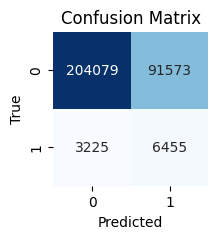

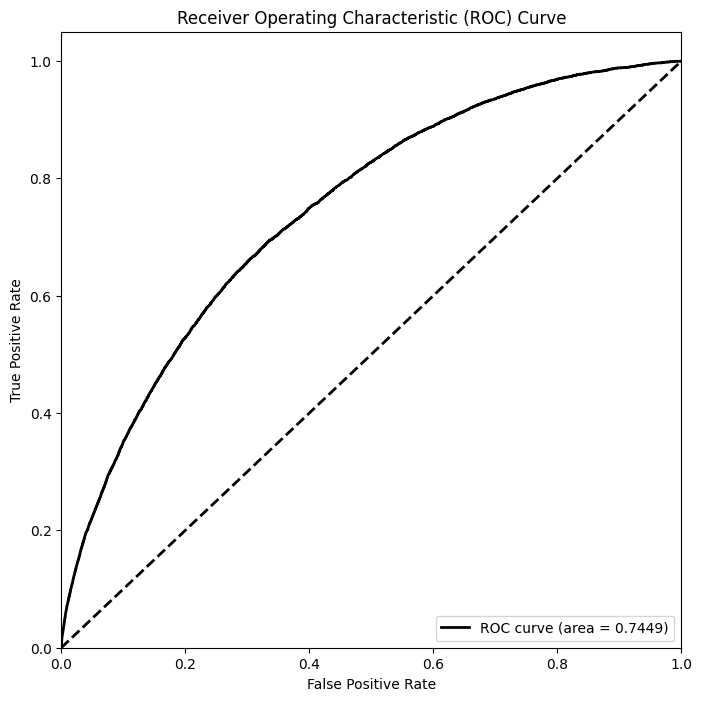

In [18]:
# Plot Confusion Matrix
plt.figure(figsize=(2,2))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Show the plot
plt.savefig("Confusion_Matrix.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='black', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.savefig("ROC_Curve.png",transparent=True,bbox_inches='tight',pad_inches=0.05,dpi=400) 
plt.show()